In [2]:
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)  # 512x512 -> 256x256
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)  # 256x256 -> 128x128

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Downsample to 256x256
        x = F.relu(self.conv2(x))  # Downsample to 128x128
        return x  # Output shape: (batch_size, 32, 128, 128)

In [4]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.convt1 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)  # 128x128 -> 256x256
        self.convt2 = nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1)  # 256x256 -> 512x512

        self.out_128 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=1)  # Output at 128x128
        self.out_256 = nn.Conv2d(in_channels=16, out_channels=3, kernel_size=1)  # Output at 256x256

    def forward(self, x):
        out_128 = torch.sigmoid(self.out_128(x))

        x = F.relu(self.convt1(x))
        out_256 = torch.sigmoid(self.out_256(x))

        x = F.relu(self.convt2(x))
        out_512 = torch.sigmoid(x)

        return out_128, out_256, out_512

In [5]:
class AutoEncoderMRL(nn.Module):
    def __init__(self):
        super(AutoEncoderMRL, self).__init__()
        self.encoder = Encoder()  # Downsampling: 512x512 -> 128x128
        self.decoder = Decoder()  # Upsampling: 128x128 -> 512x512

    def forward(self, x):
        emb = self.encoder(x)  # Get compressed representation
        out_128, out_256, out_512 = self.decoder(emb)  # Reconstruct at multiple resolutions
        return out_128, out_256, out_512, emb

In [6]:
def mrl_loss(outputs, targets, weights):
    """
    Compute the MRL loss as a weighted sum of reconstruction losses for different resolutions.

    :param outputs: Tuple containing reconstructed outputs at different resolutions (128x128, 256x256, 512x512).
    :param targets: Target images at the highest resolution (512x512).
    :param weights: List of weights for each resolution.
    :return: Combined loss value.
    """
    out_128, out_256, out_512 = outputs

    target_128 = F.interpolate(targets, size=(128, 128), mode='bilinear', align_corners=False)
    target_256 = F.interpolate(targets, size=(256, 256), mode='bilinear', align_corners=False)

    loss_128 = F.mse_loss(out_128, target_128)
    loss_256 = F.mse_loss(out_256, target_256)
    loss_512 = F.mse_loss(out_512, targets)
    print(f"Loss at 128x128: {loss_128:.4f}, Loss at 256x256: {loss_256:.4f}, Loss at 512x512: {loss_512:.4f}")
    

    # Weighted sum of losses
    total_loss = weights[0] * loss_128 + weights[1] * loss_256 + weights[2] * loss_512
    return total_loss/3

In [7]:
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Custom Dataset for loading images from a single folder
class ImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]  # Filter image files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
    
        img_path = os.path.join(self.folder_path, self.image_files[idx])

        image = Image.open(img_path)  
        if self.transform:
            image = self.transform(image)
        
        return image  


In [19]:
# Define transformations
transform = transforms.Compose([
    # transforms.Grayscale(num_output_channels=1),  # Ensure images are grayscale (if not already)
    transforms.Resize((512, 512)),  # Resize to 512x512
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # Normalize to [-1, 1]
])


folder_path_512 = 'data/train/512'
folder_path_256 = 'data/train/256'
folder_path_128 = 'data/train/128'

dataset_512 = ImageDataset(folder_path_512, transform=transform)
dataset_256 = ImageDataset(folder_path_256, transform=transform)
dataset_128 = ImageDataset(folder_path_128, transform=transform)
batch_size = 32 
dataloader_512 = DataLoader(dataset_512, batch_size=batch_size, shuffle=True)
dataloader_256 = DataLoader(dataset_256, batch_size=batch_size, shuffle=True)
dataloader_128 = DataLoader(dataset_128, batch_size=batch_size, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..1.0].


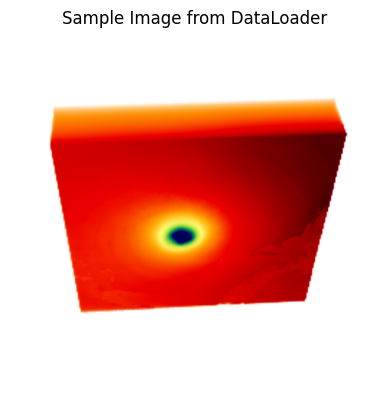

In [42]:
import matplotlib.pyplot as plt

images = next(iter(dataloader_256))

image = images[7].cpu().numpy().squeeze()
image = image.transpose(1, 2, 0)

plt.imshow(image)
plt.title("Sample Image from DataLoader")
plt.axis('off')
plt.show()

In [14]:
target_128 = F.interpolate(images, size=(128, 128), mode='bilinear', align_corners=False)
target_256 = F.interpolate(images, size=(256, 256), mode='bilinear', align_corners=False)
target_128.shape

torch.Size([16, 3, 128, 128])

In [15]:
import torch
from torch import nn
from torch.optim import Adam

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder_mrl = AutoEncoderMRL().to(device)

optimizer = Adam(autoencoder_mrl.parameters(), lr=1e-3)

mrl_weights = [1, 0.5, 0.1]  

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    autoencoder_mrl.train() 
    total_loss = 0

    for images in dataloader: 
        images = images.to(device)  

        out_128, out_256, out_512, _ = autoencoder_mrl(images)  # Outputs at 128x128, 256x256, 512x512

        loss = mrl_loss((out_128, out_256, out_512), images, mrl_weights)

        optimizer.zero_grad()  
        loss.backward()        
        optimizer.step()       
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Loss at 128x128: 0.4317, Loss at 256x256: 0.4303, Loss at 512x512: 0.4525
Loss at 128x128: 0.5703, Loss at 256x256: 0.5506, Loss at 512x512: 0.5943
Loss at 128x128: 0.4179, Loss at 256x256: 0.4248, Loss at 512x512: 0.4401
Loss at 128x128: 0.4219, Loss at 256x256: 0.4400, Loss at 512x512: 0.4515
Loss at 128x128: 0.5385, Loss at 256x256: 0.5437, Loss at 512x512: 0.5753
Loss at 128x128: 0.7172, Loss at 256x256: 0.7015, Loss at 512x512: 0.7623
Loss at 128x128: 0.3416, Loss at 256x256: 0.3684, Loss at 512x512: 0.3814
Loss at 128x128: 0.3363, Loss at 256x256: 0.3675, Loss at 512x512: 0.3812
Loss at 128x128: 0.3698, Loss at 256x256: 0.3937, Loss at 512x512: 0.4185
Loss at 128x128: 0.3898, Loss at 256x256: 0.4192, Loss at 512x512: 0.4429
Loss at 128x128: 0.4850, Loss at 256x256: 0.5034, Loss at 512x512: 0.5420
Loss at 128x128: 0.3852, Loss at 256x256: 0.4156, Loss at 512x512: 0.4439
Loss at 128x128: 0.4192, Loss at 256x256: 0.4639, Loss at 512x512: 0.4911
Loss at 128x128: 0.3555, Loss at 256x2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6784314..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


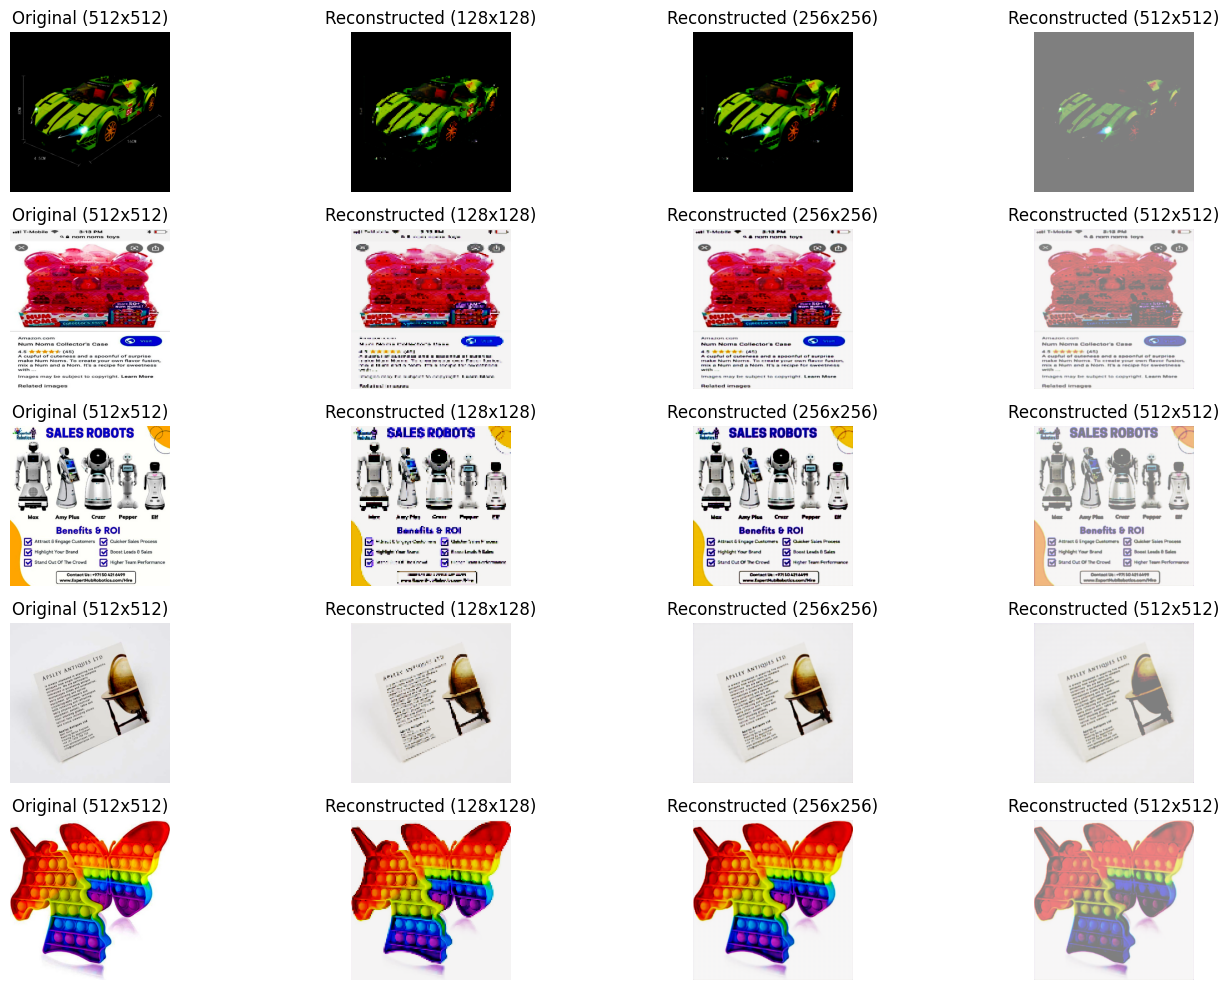

In [23]:
import matplotlib.pyplot as plt

# Set model to evaluation mode
autoencoder_mrl.eval()

images = next(iter(dataloader))
images = images.to(device)

with torch.no_grad():
    out_128, out_256, out_512, _ = autoencoder_mrl(images)

images = images.cpu().numpy()
out_128 = out_128.cpu().numpy()
out_256 = out_256.cpu().numpy()
out_512 = out_512.cpu().numpy()

# # Function to denormalize images (from [-1, 1] to [0, 1])
# def denormalize(tensor):
#     return (tensor * 0.5) + 0.5

# # Denormalize the images and outputs
# # images = denormalize(images)  # Original images
# out_128 = denormalize(out_128)  # Reconstructed 128x128
# out_256 = denormalize(out_256)  # Reconstructed 256x256
# out_512 = denormalize(out_512)  # Reconstructed 512x512

plt.figure(figsize=(15, 10))

for i in range(5):  # Visualize 5 images
    # Original image
    plt.subplot(5, 4, i * 4 + 1)
    plt.imshow(images[i].transpose(1, 2, 0)) 
    plt.title("Original (512x512)")
    plt.axis('off')

    # Reconstructed 128x128
    plt.subplot(5, 4, i * 4 + 2)
    plt.imshow(out_128[i].transpose(1, 2, 0)) 
    plt.title("Reconstructed (128x128)")
    plt.axis('off')

    # Reconstructed 256x256
    plt.subplot(5, 4, i * 4 + 3)
    plt.imshow(out_256[i].transpose(1, 2, 0)) 
    plt.title("Reconstructed (256x256)")
    plt.axis('off')

    # Reconstructed 512x512
    plt.subplot(5, 4, i * 4 + 4)
    plt.imshow(out_512[i].transpose(1, 2, 0)) 
    plt.title("Reconstructed (512x512)")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [12]:
images[1] - out_512[1]

array([[[0.09230489, 0.06378794, 0.04260391, ..., 0.03807724,
         0.07164526, 0.13948435],
        [0.03716326, 0.02385902, 0.02120388, ..., 0.03564364,
         0.01580071, 0.13810676],
        [0.02787143, 0.00965923, 0.03061432, ..., 0.01448697,
         0.05351388, 0.09177184],
        ...,
        [0.01170832, 0.01916969, 0.00777715, ..., 0.01548225,
         0.01441926, 0.05394727],
        [0.03078365, 0.00759321, 0.03535366, ..., 0.01788819,
         0.04943597, 0.08988613],
        [0.06166458, 0.0841608 , 0.03741223, ..., 0.06974983,
         0.08232844, 0.11012024]],

       [[0.13927126, 0.07075983, 0.04411119, ..., 0.04563093,
         0.06164944, 0.09073895],
        [0.06035924, 0.03126383, 0.01387656, ..., 0.01636553,
         0.01462579, 0.0800243 ],
        [0.035218  , 0.0185715 , 0.02687001, ..., 0.02506375,
         0.03474051, 0.07292944],
        ...,
        [0.02055961, 0.01546609, 0.01256663, ..., 0.02723056,
         0.0112865 , 0.27435434],
        [0.0

In [13]:
# autoencoder_mrl.eval()
# total_loss = 0

# folder_path = 'toys/test'
# dataset_test = ImageDataset(folder_path, transform=transform)  
# batch_size = 16
# dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# weights = [1.0, 1.0, 1.0]  

# with torch.no_grad():
#     for images in dataloader_test:  
#         images = images.to(device)
        
#         out_128, out_256, out_512, _ = autoencoder_mrl(images)
        
#         target_128 = F.interpolate(images, size=(128, 128), mode='bilinear', align_corners=False)
#         target_256 = F.interpolate(images, size=(256, 256), mode='bilinear', align_corners=False)
        
#         loss_128 = nn.MSELoss()(out_128, target_128)
#         loss_256 = nn.MSELoss()(out_256, target_256)
#         loss_512 = nn.MSELoss()(out_512, images)
        
#         loss = weights[0] * loss_128 + weights[1] * loss_256 + weights[2] * loss_512
#         loss /= 3
#         total_loss += loss.item()

# average_loss = total_loss / len(dataloader_test)
# print(f"Reconstruction Loss (MRL MSE): {average_loss:.4f}")


In [32]:
# Calculate reconstruction loss on the test dataset for AutoEncoderMRL
autoencoder_mrl.eval()
total_loss = 0
folder_path = 'toys/test'
dataset_test = ImageDataset(folder_path, transform=transform)  
batch_size = 16
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

mrl_weights = [1,1,1]

with torch.no_grad():  
    for images in dataloader_test:
        images = images.to(device)  

        out_128, out_256, out_512, _ = autoencoder_mrl(images)

        loss = mrl_loss((out_128, out_256, out_512), images, mrl_weights)
        total_loss += loss.item()  
average_loss = total_loss / len(dataloader_test)
print(f"Reconstruction Loss (MRL): {average_loss:.4f}")


Loss at 128x128: 0.1125, Loss at 256x256: 0.1135, Loss at 512x512: 0.3765/n
Loss at 128x128: 0.1255, Loss at 256x256: 0.1264, Loss at 512x512: 0.3847/n
Loss at 128x128: 0.0909, Loss at 256x256: 0.0920, Loss at 512x512: 0.3097/n
Loss at 128x128: 0.1909, Loss at 256x256: 0.1917, Loss at 512x512: 0.5748/n
Loss at 128x128: 0.1146, Loss at 256x256: 0.1153, Loss at 512x512: 0.3654/n
Loss at 128x128: 0.1855, Loss at 256x256: 0.1862, Loss at 512x512: 0.5943/n
Loss at 128x128: 0.1719, Loss at 256x256: 0.1729, Loss at 512x512: 0.5213/n
Loss at 128x128: 0.1009, Loss at 256x256: 0.1021, Loss at 512x512: 0.3207/n
Loss at 128x128: 0.1394, Loss at 256x256: 0.1402, Loss at 512x512: 0.4354/n
Loss at 128x128: 0.1640, Loss at 256x256: 0.1650, Loss at 512x512: 0.4888/n
Loss at 128x128: 0.0958, Loss at 256x256: 0.0970, Loss at 512x512: 0.3201/n
Loss at 128x128: 0.1440, Loss at 256x256: 0.1450, Loss at 512x512: 0.4213/n
Loss at 128x128: 0.1146, Loss at 256x256: 0.1156, Loss at 512x512: 0.3793/n
Loss at 128x